
#  EDA y Modelo de Precios — Rentas Mérida

Este notebook limpia el dataset, genera un EDA básico y entrena dos modelos de predicción de precio (Regresión Lineal y Random Forest).


In [10]:

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV = Path(r"/content/rentarenmerida.csv")
df_raw = pd.read_csv(CSV)
df_raw.head()


,bedroom,bathroom,area,parking,price
0,4,4+,300,2,"32,000"
1,2,2,140,2,"32,000"
2,6+,3,140,2,"32,000"
3,3,3,140,2,"32,000"
4,3,3,140,2,"32,000"


In [11]:

def to_int(series, default=np.nan):
    s = series.astype(str).str.extract(r'(-?\d+)')[0]
    return pd.to_numeric(s, errors="coerce").fillna(default).astype("Int64")

def money_to_float(series):
    s = series.astype(str).str.replace(r'[^0-9\.-]', '', regex=True)
    return pd.to_numeric(s, errors='coerce')


In [12]:

df = df_raw.copy()
df.columns = [c.strip().lower() for c in df.columns]
df["bedroom"]  = to_int(df["bedroom"])
df["bathroom"] = to_int(df["bathroom"])
df["parking"]  = to_int(df["parking"])
df["area"]     = pd.to_numeric(df["area"], errors="coerce").astype("Int64")
df["price"]    = money_to_float(df["price"])

df = df.dropna(subset=["price","area"]).copy()
df.head()


,bedroom,bathroom,area,parking,price
0,4,4,300,2,32000
1,2,2,140,2,32000
2,6,3,140,2,32000
3,3,3,140,2,32000
4,3,3,140,2,32000


In [13]:

# IQR outlier removal for price and area
def iqr_clip(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lo, hi

p_lo, p_hi = iqr_clip(df["price"])
a_lo, a_hi = iqr_clip(df["area"].astype(float))

df = df[(df["price"]>=p_lo) & (df["price"]<=p_hi) &
        (df["area"].astype(float)>=a_lo) & (df["area"].astype(float)<=a_hi)].copy()
df.describe().T


,count,mean,std,min,25%,50%,75%,max
bedroom,179.0,2.843575,1.037554,0.0,2.0,3.0,3.0,6.0
bathroom,179.0,2.642458,0.997517,1.0,2.0,3.0,3.0,4.0
area,179.0,288.698324,147.786205,12.0,160.0,270.0,340.0,703.0
parking,179.0,2.184358,0.767735,1.0,2.0,2.0,2.0,4.0
price,179.0,22370.391061,10611.948183,3000.0,16500.0,19000.0,29000.0,50000.0


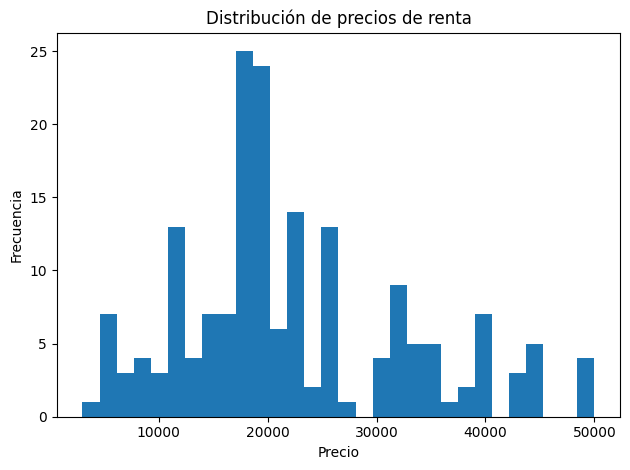

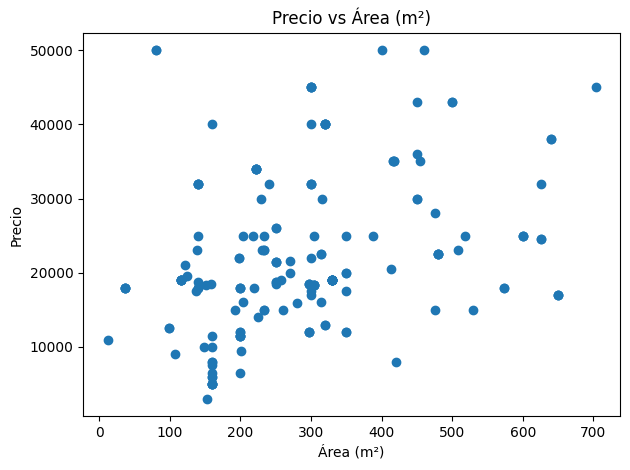

In [14]:

# Hist price
plt.figure()
df["price"].plot(kind="hist", bins=30)
plt.title("Distribución de precios de renta")
plt.xlabel("Precio"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

# Scatter area vs price
plt.figure()
plt.scatter(df["area"].astype(float), df["price"])
plt.title("Precio vs Área (m²)")
plt.xlabel("Área (m²)"); plt.ylabel("Precio")
plt.tight_layout(); plt.show()


In [16]:
# Modeling
data = df.copy()
for c in ["bedroom","bathroom","parking"]:
    data[c] = data[c].fillna(data[c].median())

X = data[["area","bedroom","bathroom","parking"]].astype(float)
y = data["price"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression().fit(X_train, y_train)
rf = RandomForestRegressor(n_estimators=300, random_state=42).fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_rf = rf.predict(X_test)

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse) # Calculate RMSE manually
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

m_lr = metrics(y_test, pred_lr)
m_rf = metrics(y_test, pred_rf)

print("LinearRegression:", m_lr)
print("RandomForestRegressor:", m_rf)

LinearRegression: {'MAE': 8076.385297140268, 'RMSE': np.float64(10897.926387493744), 'R2': 0.09238809452839392}
RandomForestRegressor: {'MAE': 6820.583995711078, 'RMSE': np.float64(10198.703463243879), 'R2': 0.2051185301867905}


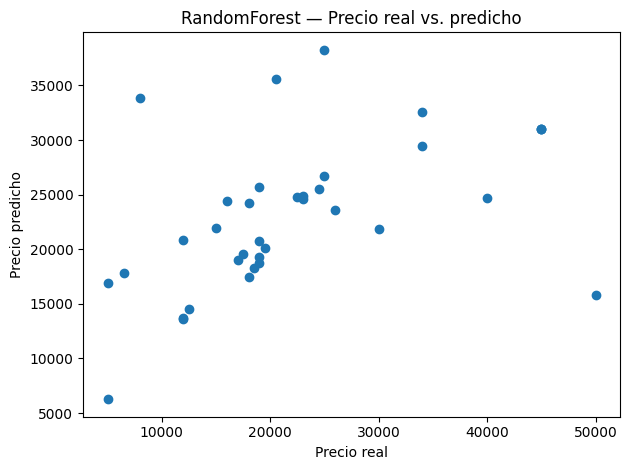

In [17]:

# Plot predicted vs actual (RF)
plt.figure()
plt.scatter(y_test, pred_rf)
plt.title("RandomForest — Precio real vs. predicho")
plt.xlabel("Precio real"); plt.ylabel("Precio predicho")
plt.tight_layout(); plt.show()
